In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
import re
import joblib
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

from pprint import pprint
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from src.p7_lightgbm import get_data
from src.p7_lightgbm import add_ratios_features, reduce_memory, timer, kfold_lightgbm_sklearn
from src.p7_lightgbm import display_importances
from src.p7_constantes import (
    NUM_THREADS,
    DATA_DIRECTORY,
    SUBMISSION_SUFIX,
    INSTALLMENTS_LAST_K_TREND_PERIODS,
    GENERATE_SUBMISSION_FILES,
    STRATIFIED_KFOLD,
    RANDOM_SEED,
    NUM_FOLDS,
    EARLY_STOPPING,
    MODEL_DIR,
)

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

# Configuration

In [4]:



"""# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
#NUM_FOLDS = 5
EARLY_STOPPING = 100
#EARLY_STOPPING = 50"""

"""LIGHTGBM_PARAMS = {
    "boosting_type": "goss",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}
"""


'LIGHTGBM_PARAMS = {\n    "boosting_type": "goss",\n    "n_estimators": 10000,\n    "learning_rate": 0.005134,\n    "num_leaves": 54,\n    "max_depth": 10,\n    "subsample_for_bin": 240000,\n    "reg_alpha": 0.436193,\n    "reg_lambda": 0.479169,\n    "colsample_bytree": 0.508716,\n    "min_split_gain": 0.024766,\n    "subsample": 1,\n    "is_unbalance": False,\n    "silent": -1,\n    "verbose": -1,\n}\n'

# Joindre et nettoyer les données

In [6]:
df = get_data(debug=False)

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_lightgbm.py:538: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval("np.{}".format(function_name))(


Application dataframe shape:  (356250, 83)
application_train and application_test - done in 6s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 14s
Previous dataframe shape:  (338857, 225)
previous_application - done in 21s
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 101)
Credit card dataframe shape:  (103558, 59)
previous applications balances - done in 462s
Initial df memory usage is 1791.14 MB for 659 columns
Final memory usage is: 714.49 MB - decreased by 60.1%


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Columns: 659 entries, SK_ID_CURR to DAYS_CREDIT_MEAN_TO_EMPLOYED
dtypes: float16(342), float32(235), float64(56), int16(2), int32(1), int8(23)
memory usage: 714.5 MB


In [8]:
lgbm_categorical_feat = [
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "NAME_CONTRACT_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "NAME_INCOME_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
    "WEEKDAY_APPR_PROCESS_START",
    "NAME_TYPE_SUITE",
    "WALLSMATERIAL_MODE",
]


In [9]:
with timer("Run LightGBM"):
    feat_importance = kfold_lightgbm_sklearn(df, lgbm_categorical_feat)
    print(feat_importance)

Train/valid shape: (307506, 659), test shape: (48744, 659)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4001]	training's auc: 0.927405	training's binary_logloss: 0.177766	valid_1's auc: 0.794021	valid_1's binary_logloss: 0.233959
Fold  1 AUC : 0.794021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2959]	training's auc: 0.904675	training's binary_logloss: 0.189443	valid_1's auc: 0.796343	valid_1's binary_logloss: 0.236184
Fold  2 AUC : 0.796343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3410]	training's auc: 0.914977	training's binary_logloss: 0.185062	valid_1's auc: 0.802564	valid_1's binary_logloss: 0.22583
Fold  3 AUC : 0.802564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2771]	training's auc: 0.899841	training's binary_logloss: 0.191641	valid_1's auc: 0.799835	valid_1's bi

# Feature importance

Démarrer

In [11]:
feature_importance = pd.read_csv(os.path.join(MODEL_DIR, "feature_importance_model2_04.csv"))

In [10]:
"""
Dans le contexte de LightGBM, deux mesures différentes de l'importance des features :
le "gain" mesure l'impact de chaque attribut sur la performance du modèle, 
tandis que le "split" mesure la fréquence à laquelle chaque attribut est utilisé pour diviser les données.
"""

'\nDans le contexte de LightGBM, deux mesures différentes de l\'importance des features :\nle "gain" mesure l\'impact de chaque attribut sur la performance du modèle, \ntandis que le "split" mesure la fréquence à laquelle chaque attribut est utilisé pour diviser les données.\n'

In [12]:
feature_importance

,feature,gain,split
0,EXT_SOURCES_MEAN,622359.285071,1559.2
1,EXT_SOURCES_NANMEDIAN,350225.289836,1306.1
2,ORGANIZATION_TYPE,182800.656338,7014.2
3,EXT_SOURCES_MIN,170610.149319,1273.7
4,EXT_SOURCES_MAX,121823.645406,974.9
...,...,...,...
652,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,1.760610,0.1
653,APPROVED_DAYS_LAST_DUE_DIFF_MAX,0.000000,0.0
654,APPROVED_DAYS_LAST_DUE_DIFF_MEAN,0.000000,0.0
655,APPROVED_DAYS_LAST_DUE_DIFF_MIN,0.000000,0.0


## Importance Gain

In [12]:
"""
Le gain représente l'augmentation moyenne de la métrique de performance (par exemple, l'AUC, l'erreur quadratique moyenne, etc.)
obtenue lorsqu'un attribut est utilisé pour diviser les données. 
Plus précisément, le gain est calculé en mesurant la réduction de l'erreur que chaque division d'attribut apporte au modèle.
"""

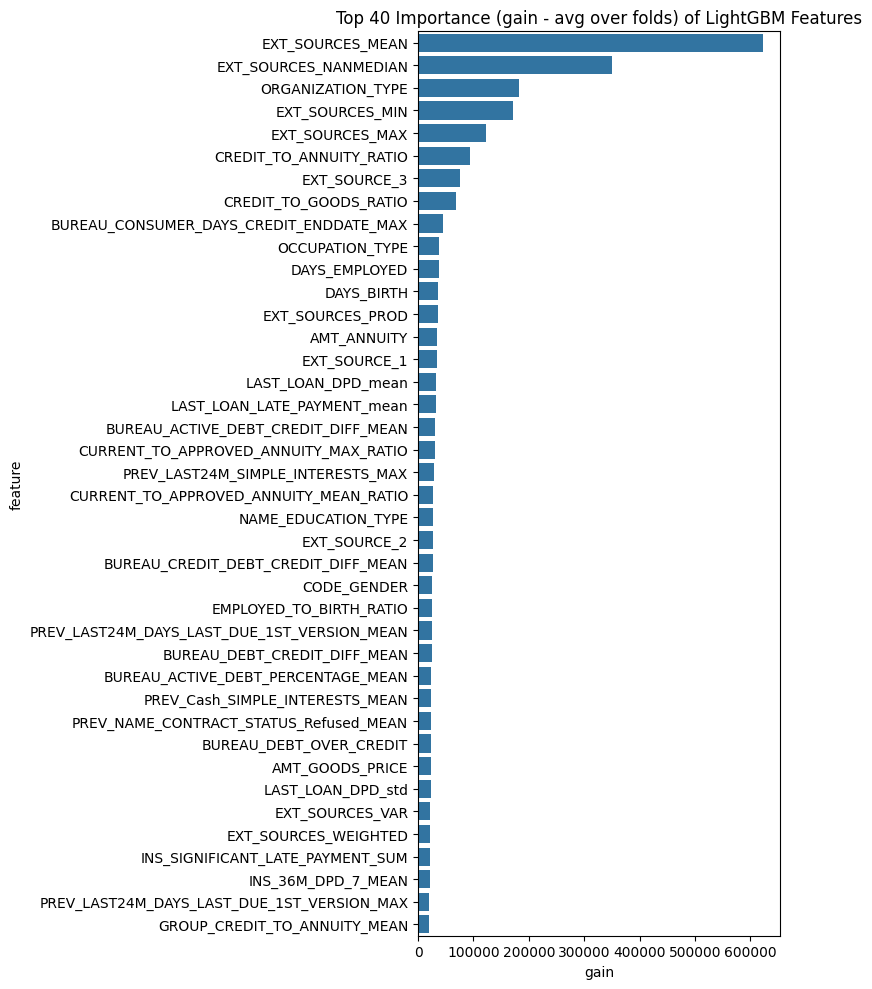

In [8]:
display_importances(feature_importance, importance='gain')

## Importance Split

In [ ]:
"""
Le split représente le nombre de fois où un attribut est utilisé pour diviser les données lors de la construction de l'arbre de décision. 
En d'autres termes, il mesure le nombre de fois où un attribut est sélectionné comme le meilleur attribut pour diviser les données
dans l'ensemble des arbres de décision de l'ensemble de modèles.
"""

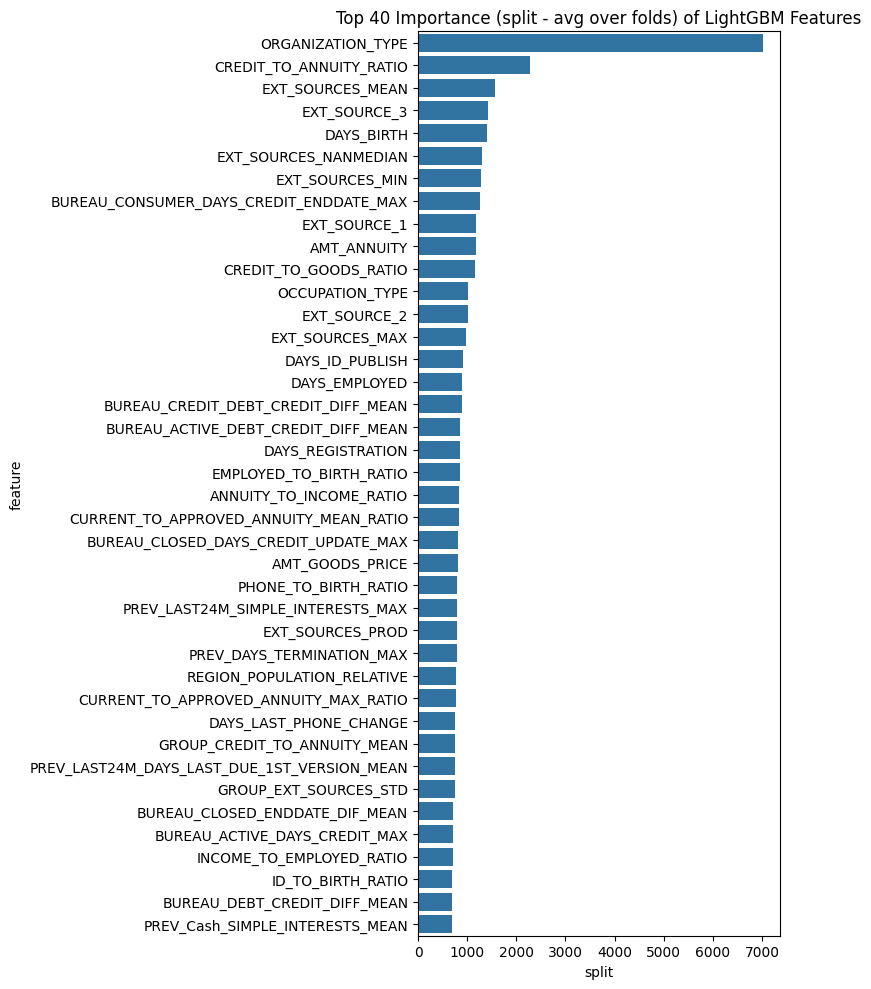

In [9]:
display_importances(feature_importance, importance='split')

Features à conserver

In [23]:
top = 14
top = 18
features = feature_importance.sort_values(by='split', ascending=False).head(top)['feature'].values.tolist()
features

['ORGANIZATION_TYPE',
 'CREDIT_TO_ANNUITY_RATIO',
 'EXT_SOURCES_MEAN',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCES_NANMEDIAN',
 'EXT_SOURCES_MIN',
 'BUREAU_CONSUMER_DAYS_CREDIT_ENDDATE_MAX',
 'EXT_SOURCE_1',
 'AMT_ANNUITY',
 'CREDIT_TO_GOODS_RATIO',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCES_MAX',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN']

In [ ]:
"""
"feature": "ORGANIZATION_TYPE", "table": "application", "description": "Type of organization where client works", "agg": None

CREDIT_TO_ANNUITY_RATIO:
bureau["CREDIT_TO_ANNUITY_RATIO"] = bureau["AMT_CREDIT_SUM"] / bureau["AMT_ANNUITY"]
prev["CREDIT_TO_ANNUITY_RATIO"] = prev["AMT_CREDIT"] / prev["AMT_ANNUITY"]
(df=Application) df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]

"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": None
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": None

EXT_SOURCES_MEAN
for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXT_SOURCES_{}".format(function_name.upper())
        df[feature_name] = eval("np.{}".format(function_name))(
            df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
        )

On va éviter une multicolinéarité trop forte en ne prenant pas toutes les features ext_sources. On va garder la EXT_SOURCES_MEAN et la EXT_SOURCE_3
"feature": "EXT_SOURCE_1", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_2", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_3", "table": "application", "description": "Normalized score from external data source", "agg": "None"

"feature": "DAYS_BIRTH", "table": "application", "description": "Client's age in days at the time of application", "agg": "None"

"feature": "DAYS_CREDIT_ENDDATE", "table": "bureau", "description": "Remaining duration of CB credit (in days) at the time of application in Home Credit", "agg": "max"

# On ne garde pas AMT_ANNUITY ?? Faire une matrice de corrélation ?
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": "None"

CREDIT_TO_GOODS_RATIO
df["CREDIT_TO_GOODS_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": "None"
"feature": "AMT_GOODS_PRICE", "table": "application", "description": "For consumer loans it is the price of the goods for which the loan is given", "agg": "None"


"feature": "OCCUPATION_TYPE", "table": "application", "description": "What kind of occupation does the client have", "agg": "None"

"feature": "DAYS_ID_PUBLISH", "table": "application", "description": "How many days before the application did client change the identity document with which he applied for the loan", "agg": "None"

"feature": "DAYS_EMPLOYED", "table": "application", "description": "How many days before the application the person started current employment", "agg": "None"

BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN
bureau["DEBT_CREDIT_DIFF"] = (
        bureau["AMT_CREDIT_SUM"] - bureau["AMT_CREDIT_SUM_DEBT"]
    )
    
# General loans aggregations
    agg_bureau = group(bureau, "BUREAU_", BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    agg_bureau = group_and_merge(
        active, agg_bureau, "BUREAU_ACTIVE_", BUREAU_ACTIVE_AGG
    )
BUREAU_AGG = {
    "DEBT_CREDIT_DIFF": ["mean", "sum"],
    
"feature": "AMT_CREDIT_SUM", "table": "bureau", "description": "Current credit amount for the Credit Bureau credit", "agg": "None"
"feature": "AMT_CREDIT_SUM_DEBT", "table": "bureau", "description": "Current debt on Credit Bureau credit", "agg": "None"  
    
    
Pour le Last loan, c'est intéressant mais plus compliqué. A priori ce serait le nombre de jours d'impayés du dernier emprunt précédent
installments_payments.csv
pay["DPD"] = pay["DAYS_ENTRY_PAYMENT"] - pay["DAYS_INSTALMENT"]
    pay["DPD"] = pay["DPD"].apply(lambda x: 0 if x <= 0 else x)
DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)
DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)
"""